In [72]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from new_flows.dimension_scaling import ScalingTransform
from new_flows.translation import TranslatingTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


from nflows.transforms.nonlinearities import Tanh, LeakyReLU
from nflows.transforms.linear import NaiveLinear


In [73]:
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    Found from https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('./pickled_files/siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n, noise=0.1):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ 
        two half-moons taken from an example 
    """
    def sample(self, n, noise=0.1):
        moons = datasets.make_moons(n_samples=n, noise=noise)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n, noise=0.1):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

(-1.5, 2.5)

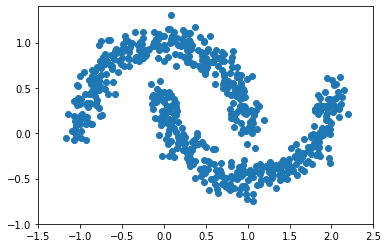

In [77]:
d = DatasetMoons()
x = d.sample(128*5, noise=.1)

xrange = [-1.5, 2.5]
yrange = [-1, 1.4]

plt.scatter(x[:, 0], x[:, 1]);
plt.ylim(*yrange)
plt.xlim(*xrange)


(-2.5, 2.8)

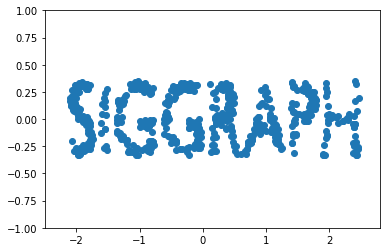

In [67]:
d = DatasetSIGGRAPH()
x = d.sample(128*5, noise=.1)

xrange = [-2.5, 2.8]
yrange = [-1, 1]

plt.scatter(x[:, 0], x[:, 1]);
plt.ylim(*yrange)
plt.xlim(*xrange)

(-4.0, 4.0)

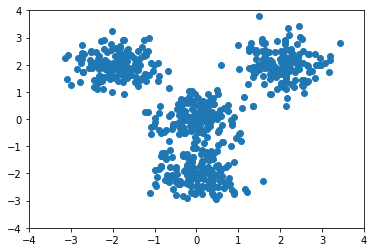

In [37]:
d = DatasetMixture()
x = d.sample(128*5, noise=.1)

xrange = [-4, 4]
yrange = [-4, 4]

plt.scatter(x[:, 0], x[:, 1]);
plt.ylim(*yrange)
plt.xlim(*xrange)

In [83]:
num_layers = 10
base_dist = StandardNormal(shape=[2])

transforms = []
transforms.append(ScalingTransform(dim=2, negative=False))
transforms.append(TranslatingTransform(dim=2))


for i in range(num_layers):
    # transforms.append(ReversePermutation(features=2))
    # if i % 2 == 0:
    #     transforms.append(ScalingTransform(dim=2, negative=True) )

    # if i % 2 == 1:
    #     transforms.append(ScalingTransform(dim=2, negative=False))

    if i % 2:
        transforms.append(ReversePermutation(features=2)

    #transforms.append(NaiveLinear(features=2))
    # if i == 2:
    #     transforms.append(LeakyReLU())
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=24))



    #transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

SyntaxError: invalid syntax (<ipython-input-83-6e01282738b1>, line 24)

In [82]:
optimizer = optim.Adam(flow.parameters(), lr=0.001)

/Users/Herb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Loss: 9.45590


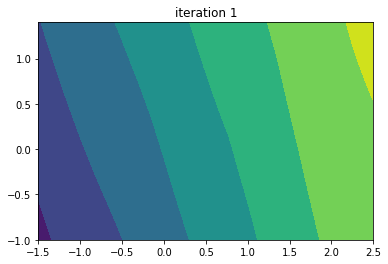

Loss: 7.00257
Loss: 4.76507
Loss: 4.58280
Loss: 4.54187
Loss: 4.40529
Loss: 4.25722
Loss: 4.17924
Loss: 4.08488
Loss: 3.93672
Loss: 3.87781


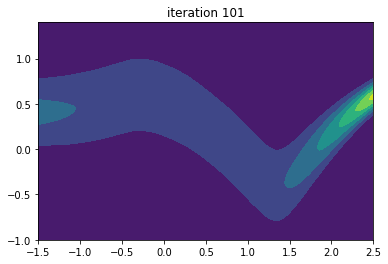

Loss: 3.77853
Loss: 3.73230
Loss: 3.58698
Loss: 3.50603
Loss: 3.42820
Loss: 3.25149
Loss: 3.23487
Loss: 3.17435
Loss: 3.10083
Loss: 2.98987


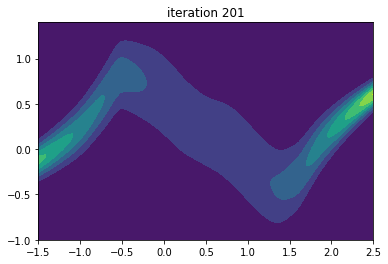

Loss: 2.93848
Loss: 2.83986
Loss: 2.78099
Loss: 2.67821
Loss: 2.58990
Loss: 2.53792
Loss: 2.48206
Loss: 2.42885
Loss: 2.33226
Loss: 2.32782


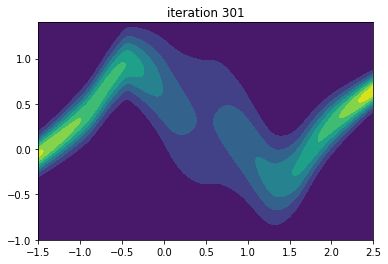

Loss: 2.19289
Loss: 2.16568
Loss: 2.07641
Loss: 2.11706
Loss: 2.02696
Loss: 1.97189
Loss: 1.84904
Loss: 1.84133
Loss: 1.77677
Loss: 1.74058


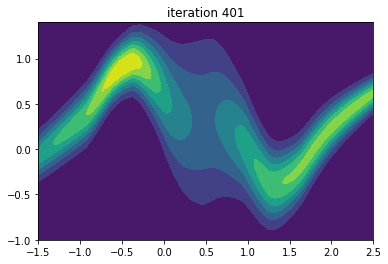

Loss: 1.68052
Loss: 1.80850
Loss: 1.61850
Loss: 1.63249
Loss: 1.65547
Loss: 1.64129
Loss: 1.58418
Loss: 1.61061
Loss: 1.63276
Loss: 1.59484


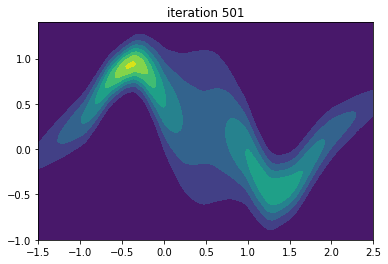

Loss: 1.50710
Loss: 1.55151
Loss: 1.55826
Loss: 1.53223
Loss: 1.52236
Loss: 1.49795
Loss: 1.60467
Loss: 1.51501
Loss: 1.53834
Loss: 1.58298


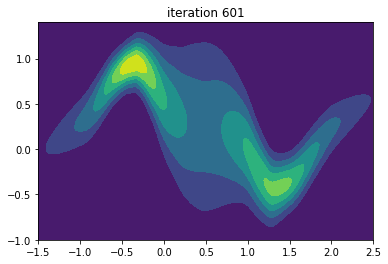

Loss: 1.56529
Loss: 1.49258
Loss: 1.49089
Loss: 1.52409
Loss: 1.52503
Loss: 1.53493
Loss: 1.52245
Loss: 1.55107
Loss: 1.47896
Loss: 1.55845


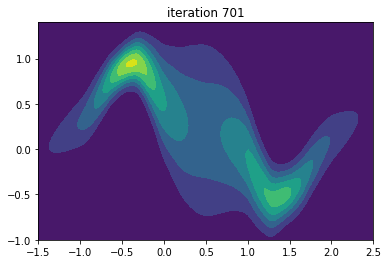

Loss: 1.52565
Loss: 1.67912
Loss: 1.56498
Loss: 1.51415
Loss: 1.55193
Loss: 1.55456
Loss: 1.50115
Loss: 1.55590
Loss: 1.54330
Loss: 1.52549


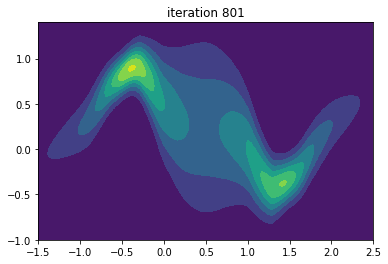

Loss: 1.55103
Loss: 1.51617
Loss: 1.49345
Loss: 1.48846
Loss: 1.53452
Loss: 1.52798
Loss: 1.47919
Loss: 1.51277
Loss: 1.50211
Loss: 1.48956


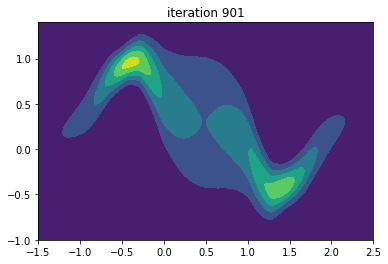

Loss: 1.60495
Loss: 1.50712
Loss: 1.53104
Loss: 1.50214
Loss: 1.49090
Loss: 1.50344
Loss: 1.49079
Loss: 1.54469
Loss: 1.55669
Loss: 1.48681


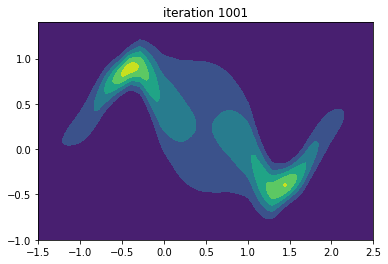

Loss: 1.52095
Loss: 1.52677
Loss: 1.53931
Loss: 1.55497
Loss: 1.51944
Loss: 1.54683
Loss: 1.48637
Loss: 1.47366
Loss: 1.46089
Loss: 1.56977


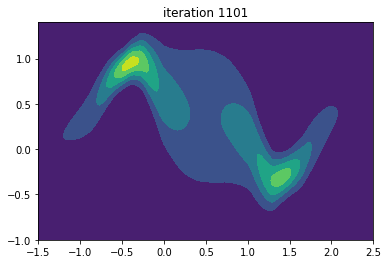

Loss: 1.55721
Loss: 1.54998
Loss: 1.51005
Loss: 1.57977
Loss: 1.46680
Loss: 1.54028
Loss: 1.53756
Loss: 1.45165
Loss: 1.51470
Loss: 1.55178


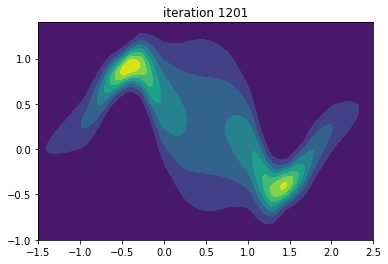

Loss: 1.56935
Loss: 1.46600
Loss: 1.49342
Loss: 1.54234
Loss: 1.48354
Loss: 1.54486
Loss: 1.50698
Loss: 1.45732
Loss: 1.49748
Loss: 1.49528


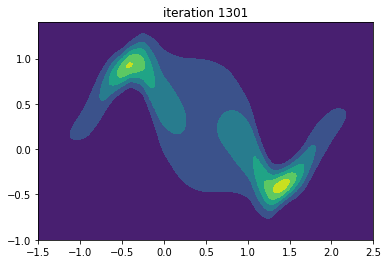

Loss: 1.51009
Loss: 1.46222
Loss: 1.50757
Loss: 1.51727
Loss: 1.53117
Loss: 1.50354
Loss: 1.48620
Loss: 1.52062
Loss: 1.56556
Loss: 1.50802


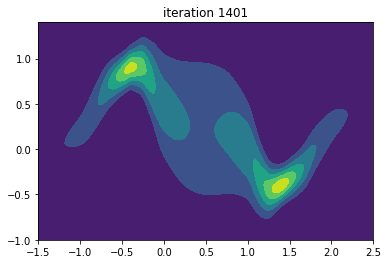

Loss: 1.53003
Loss: 1.41694
Loss: 1.54875
Loss: 1.48611
Loss: 1.50453
Loss: 1.53509
Loss: 1.51400
Loss: 1.51915
Loss: 1.57949
Loss: 1.54084


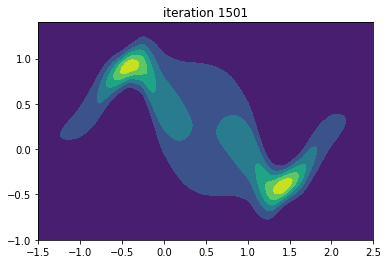

Loss: 1.53642
Loss: 1.52488
Loss: 1.43020
Loss: 1.63188
Loss: 1.54762
Loss: 1.51978
Loss: 1.50379
Loss: 1.47391
Loss: 1.49694
Loss: 1.47596


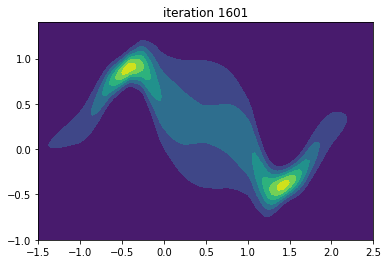

Loss: 1.51295
Loss: 1.51062
Loss: 1.48730
Loss: 1.47868
Loss: 1.48002
Loss: 1.45613
Loss: 1.53498
Loss: 1.52575
Loss: 1.49987
Loss: 1.52395


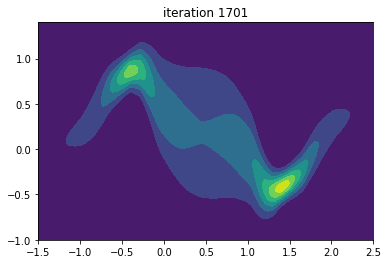

Loss: 1.56164
Loss: 1.48075
Loss: 1.46297
Loss: 1.50098
Loss: 1.48062
Loss: 1.58747
Loss: 1.46314
Loss: 1.47804
Loss: 1.51030
Loss: 1.55021


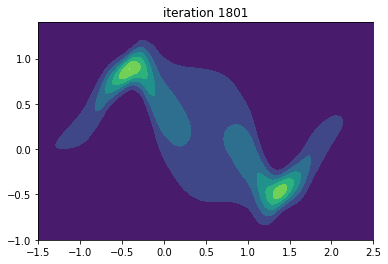

Loss: 1.49041
Loss: 1.47359
Loss: 1.51012
Loss: 1.55249
Loss: 1.47154
Loss: 1.55749
Loss: 1.49579
Loss: 1.47453
Loss: 1.46453
Loss: 1.50972


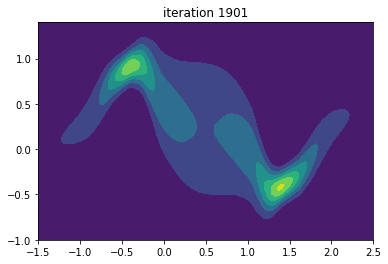

Loss: 1.47195
Loss: 1.49338
Loss: 1.54024
Loss: 1.45990
Loss: 1.41271
Loss: 1.52052
Loss: 1.46129
Loss: 1.46751
Loss: 1.54768
Loss: 1.49918


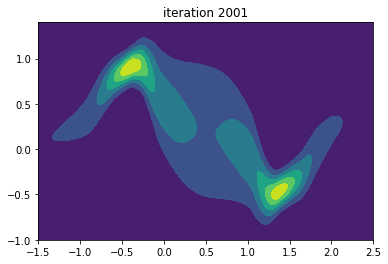

Loss: 1.45802
Loss: 1.52087
Loss: 1.57943
Loss: 1.49858


KeyboardInterrupt: 

In [80]:
flow.train()
num_iter = 9000
for i in range(num_iter):
    x = d.sample(128*2, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()

    if i % 10 == 0: 
        print(f"Loss: {loss :.5f}")
    
    if i % 500 == 0:
        xline = torch.linspace(*xrange)
        yline = torch.linspace(*yrange)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

xline = torch.linspace(*xrange)
yline = torch.linspace(*yrange)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
plt.title('iteration {}'.format(num_iter))
plt.show()

In [45]:
# sample_tensor = torch.randn(2)
# print(sample_tensor.shape)
# x = d.sample(5) 
# print(x)
# print(sample_tensor.unsqueeze(0).repeat(5,1))

# print( x + sample_tensor.unsqueeze(0).repeat(5,1))

tensor([ 0.0788, -0.0225], grad_fn=<SelectBackward>)
tensor([-0.1055,  0.0074], grad_fn=<SelectBackward>)
(1024, 2)
(1280, 2)
torch.Size([256, 2])


Text(0.5, 1.0, 'z -> x')

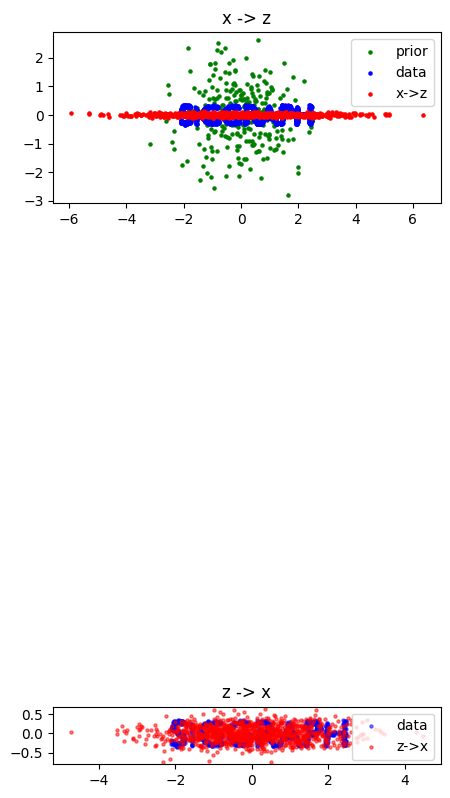

In [71]:
flow.eval()
# this is the data 
x = d.sample(256*5, noise=0.1)
# This is the output from the NF model by taking sampling values x and going to z x->z  
z = flow.sample(128*8)
z2, logabsdet = transform.inverse(z)

print(z[0])
print(z2[0])

x = x.detach().numpy()
z = z.detach().numpy()
z2 = z2.detach().numpy()
# This is sampling from the prior distribution 
p = base_dist.sample(256)

print(z.shape)
print(x.shape)
print(p.shape)


plt.figure(figsize=(5,15), dpi=100)
plt.subplot(211)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.scatter(z2[:,0], z2[:,1], c='r', s=5)
plt.legend(['prior', 'data', 'x->z', "other"])
plt.axis('scaled')
# plt.ylim(-2, 2)
# plt.xlim(-2, 2)
plt.title('x -> z')

z = flow.sample(128*8)
z = z.detach().numpy()
plt.subplot(212)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')